# Analysis on Reddit Posts

In [2]:
# Import libraries

# Usual libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import re
import string
import random

# NLTK
import nltk
from nltk.tokenize import regexp_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Assigning variables
lemmatizer = nltk.stem.WordNetLemmatizer()
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
stop_words = stopwords.words('english')

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

# Models
from sklearn.linear_model import LogisticRegression
#import xgboost as xgb
#import lightgbm as gbm
#from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier

# Doc/Word Vectors
from gensim.models.fasttext import FastText
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary

# LDA and LSI Models
from sklearn.decomposition import LatentDirichletAllocation as LDA
from gensim.models import LsiModel, CoherenceModel
from gensim.models import TfidfModel
from gensim.models import LdaModel, LdaMulticore
from gensim import corpora, models
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# Spacy
import spacy
from spacy.lang.en.examples import sentences
from spacy import displacy
from spacytextblob.spacytextblob import SpacyTextBlob
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe('spacytextblob')
stopwords_nlp = nlp.Defaults.stop_words

# LIME and SHAP
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer
#import shap

# Set seed
np.random.seed(123)

In [3]:
# Import dataset
import os
os.chdir('/Users/daltonanderson/Documents/USF/Fall-2022/ISM6930 Text Analytics/Final Project Text Analysis on Social Platforms/Reddit')

df = pd.read_csv (r'iran_protest_corpus.csv')
df.head()

,id,subreddit,body,created
0,ipwiccq,worldnews,> Iran protests Western stance on mass protest...,1.664147e+09
1,ipvtdwd,worldnews,"Iran for the past 40+ years: ""Fuck the west"" ...",1.664137e+09
2,ipvyfc3,worldnews,""" ... over what it called interference and ho...",1.664139e+09
3,ipvpcc7,worldnews,We should protest their protest response prote...,1.664135e+09
4,ipvrv10,worldnews,"This is the best tl;dr I could make, [original...",1.664136e+09


## Data Cleaning

In [4]:
# Check for duplicates and drop if any
print(len(df))
df.drop_duplicates(['id'])
print(len(df))

8073
8073


In [5]:
# Loop through the column and clean the data

new_text = []

for text in df['body']:
    text = re.sub(r'[!"#$%&()*+,-./:;<=>?[\]^_`{|}~]', ' ', text).lower()               # Remove punctuation and make the letters lowercase
        
    words = nltk.tokenize.word_tokenize(text)                                           # Tokenize the text
    words = [w for w in words if w.isalpha()]                                           # Ensure the data is alphabets (remove numbers)
    words = [w for w in words if len(w)>1 and w not in stopwords.words('english')]      # Remove words that are less than 2 characters and stop words as well
        
    words = [lemmatizer.lemmatize(w) for w in words]                                    # Lemmatize the words
    new_text.append(' '.join(words))

# Make a copy of the original dataframe and add the cleaned text into a new column
df['cleaned_text'] = new_text
df.head()

,id,subreddit,body,created,cleaned_text
0,ipwiccq,worldnews,> Iran protests Western stance on mass protest...,1.664147e+09,iran protest western stance mass protest woman...
1,ipvtdwd,worldnews,"Iran for the past 40+ years: ""Fuck the west"" ...",1.664137e+09,iran past year fuck west west dont like irania...
2,ipvyfc3,worldnews,""" ... over what it called interference and ho...",1.664139e+09,called interference hostile medium coverage na...
3,ipvpcc7,worldnews,We should protest their protest response prote...,1.664135e+09,protest protest response protest response
4,ipvrv10,worldnews,"This is the best tl;dr I could make, [original...",1.664136e+09,best tl dr could make original http www reuter...


## EDA

<AxesSubplot:title={'center':'Subreddits'}>

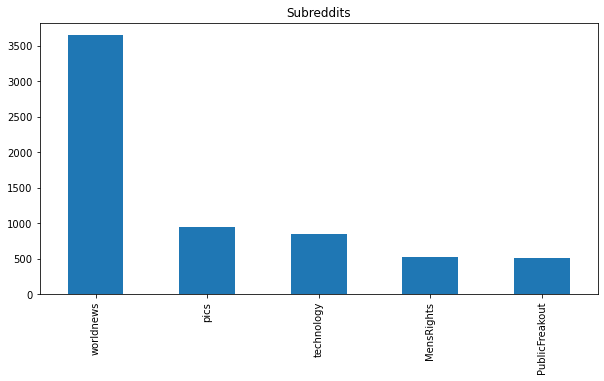

In [7]:
# Plot number of sources
df['subreddit'].value_counts().nlargest(5).plot(kind='bar', figsize=(10,5), title="Subreddits")

## Sentiment Analysis

In [8]:
# Creating a copy of the dataframe
df_sentiment = df.copy()

In [9]:
df_sentiment['compound'] = df_sentiment['body'].apply(lambda x:SentimentIntensityAnalyzer().polarity_scores(x)['compound'])
df_sentiment['positive'] = df_sentiment['body'].apply(lambda x:SentimentIntensityAnalyzer().polarity_scores(x)['pos'])
df_sentiment['negative'] = df_sentiment['body'].apply(lambda x:SentimentIntensityAnalyzer().polarity_scores(x)['neg'])
df_sentiment.head()

,id,subreddit,body,created,cleaned_text,compound,positive,negative
0,ipwiccq,worldnews,> Iran protests Western stance on mass protest...,1.664147e+09,iran protest western stance mass protest woman...,-0.8074,0.083,0.348
1,ipvtdwd,worldnews,"Iran for the past 40+ years: ""Fuck the west"" ...",1.664137e+09,iran past year fuck west west dont like irania...,-0.7097,0.000,0.258
2,ipvyfc3,worldnews,""" ... over what it called interference and ho...",1.664139e+09,called interference hostile medium coverage na...,-0.9753,0.060,0.350
3,ipvpcc7,worldnews,We should protest their protest response prote...,1.664135e+09,protest protest response protest response,-0.5994,0.000,0.496
4,ipvrv10,worldnews,"This is the best tl;dr I could make, [original...",1.664136e+09,best tl dr could make original http www reuter...,-0.9666,0.047,0.204


In [11]:
print('Compound:', df_sentiment['compound'].mean())
print('Positive:', df_sentiment['positive'].mean())
print('Negative:', df_sentiment['negative'].mean())

Compound: -0.025824080267558534
Positive: 0.11820128824476642
Negative: 0.1116451133407656


Text(0.5, 1.0, 'Polarity Score Distribution')

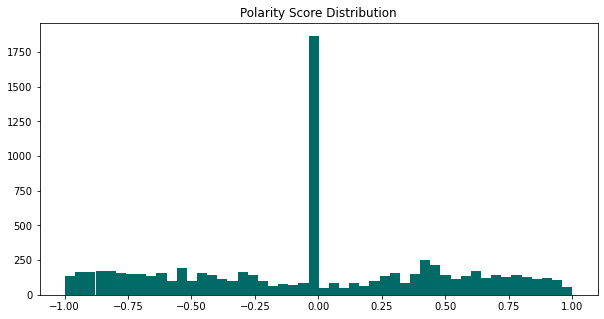

In [12]:
plt.figure(figsize=(10,5))
plt.hist(df_sentiment['compound'], bins = 50, color = '#006B66')
# plt.ylim(0,200)
plt.title('Polarity Score Distribution')

In [13]:
# Trying Spacy
# lets create a new column with the sentiment of the comment

df_sentiment['sentiment'] = df_sentiment['body'].apply(lambda x: nlp(x)._.blob.polarity)

In [14]:
print('Text Blob Polartiy Score:', df_sentiment['sentiment'].mean())

Text Blob Polartiy Score: 0.055881402874080346


Text(0.5, 1.0, 'Polarity Score Distribution')

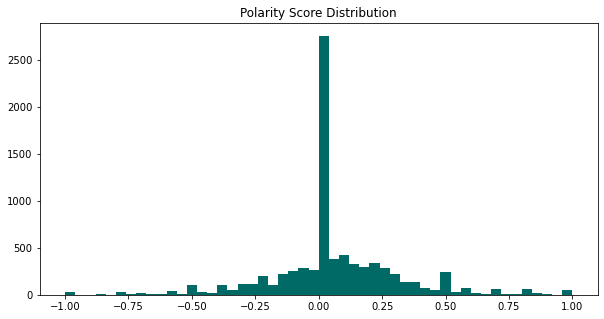

In [16]:
plt.figure(figsize=(10,5))
plt.hist(df_sentiment['sentiment'], bins = 50, color = '#006B66')
# plt.ylim(0,200)
plt.title('Polarity Score Distribution')

In [19]:
import pandas as pd
import numpy as np
df_hate = pd.read_csv(r'ethnic_slurs.csv')
disability_slurs = pd.read_csv(r'disability_words.csv')

df_hate.head(), disability_slurs.head()

(                Term                       Location  \
 0    abbie abe abie                  north america    
 1               abc                      east asia    
 2              abcd         south asians in the us    
 3  abidabeed plural   middle east and north africa    
 4           aboabbo                      australia    
 
                                               Target  \
 0                                        jewish men    
 1  americanborn chinese han or other chinese incl...   
 2  americanborn confused desi indian americans or...   
 3                              black african people    
 4                      australian aboriginal person    
 
                                              Meaning  
 0  originated before the 1950s from the proper na...  
 1  the term implies an otherness or lack of conne...  
 2  used chiefly by south asian immigrants to impl...  
 3  arabic for slave associated with the arab slav...  
 4  originally this was simply an info

In [20]:
def clean_text(text):
    # make everything lowercase
    text = text.lower()
    # only lowercase letters no numbers or special characters
    text = re.sub(r'[^a-z]', ' ', text)
    
    # only accept nouns, pronouns and entities
    doc = nlp(text)
    text = [token.text for token in doc if token.pos_ in ['NOUN', 'PROPN', 'PRON', 'ADJ'] and len(token.text) > 3]
    return text

In [21]:
df['title'] = df['body'].apply(clean_text)
df.head()

,id,subreddit,body,created,cleaned_text,title
0,ipwiccq,worldnews,> Iran protests Western stance on mass protest...,1.664147e+09,iran protest western stance mass protest woman...,"[iran, western, stance, mass, protests, woman,..."
1,ipvtdwd,worldnews,"Iran for the past 40+ years: ""Fuck the west"" ...",1.664137e+09,iran past year fuck west west dont like irania...,"[iran, past, years, west, west, iranian, gover..."
2,ipvyfc3,worldnews,""" ... over what it called interference and ho...",1.664139e+09,called interference hostile medium coverage na...,"[what, interference, hostile, media, coverage,..."
3,ipvpcc7,worldnews,We should protest their protest response prote...,1.664135e+09,protest protest response protest response,"[their, protest, response, protests, response]"
4,ipvrv10,worldnews,"This is the best tl;dr I could make, [original...",1.664136e+09,best tl dr could make original http www reuter...,"[this, best, original, https, reuters, world, ..."


In [22]:
# lets create a new column with the length of the comment
df['length'] = df['title'].apply(lambda x: len(x))
df.head()

,id,subreddit,body,created,cleaned_text,title,length
0,ipwiccq,worldnews,> Iran protests Western stance on mass protest...,1.664147e+09,iran protest western stance mass protest woman...,"[iran, western, stance, mass, protests, woman,...",12
1,ipvtdwd,worldnews,"Iran for the past 40+ years: ""Fuck the west"" ...",1.664137e+09,iran past year fuck west west dont like irania...,"[iran, past, years, west, west, iranian, gover...",8
2,ipvyfc3,worldnews,""" ... over what it called interference and ho...",1.664139e+09,called interference hostile medium coverage na...,"[what, interference, hostile, media, coverage,...",28
3,ipvpcc7,worldnews,We should protest their protest response prote...,1.664135e+09,protest protest response protest response,"[their, protest, response, protests, response]",5
4,ipvrv10,worldnews,"This is the best tl;dr I could make, [original...",1.664136e+09,best tl dr could make original http www reuter...,"[this, best, original, https, reuters, world, ...",84


In [23]:
all_comments = ' '.join(df['title'].apply(lambda x: ' '.join(x)))
len(all_comments)

669788

In [24]:
# check how many unique words are in the comments
total_unique = len(set(all_comments.split()))

# average unique words per comment
unique_words_by_comment = len(set(all_comments.split())) / len(all_comments.split())

In [25]:
# check how many total words are in the comments
total_words = len(all_comments.split())
total_words

92612

In [26]:
# check how many average words are in the comments
average_words_by_comment = len(all_comments.split()) / len(df)
average_words_by_comment

11.471819645732689

In [27]:
# r strip Location column
df_hate['Location'] = df_hate['Location'].apply(lambda x: x.rstrip())

In [28]:
# make a set of all unique words in Term 
hate_terms = set()
for term in df_hate['Term']:
    for word in term.split():
        if len(word) < 4:
            continue
        hate_terms.add(word)

In [29]:
# check if the comments contain any of the hate words
hate_score = []
for comment in df['title']:
    hate_count = 0
    for content in comment:
        for word in hate_terms:
            if word in content:
                hate_count += 1

    hate_score.append(hate_count)

# add the hate score to the dataframe
df['hate_score'] = hate_score
df.head()

,id,subreddit,body,created,cleaned_text,title,length,hate_score
0,ipwiccq,worldnews,> Iran protests Western stance on mass protest...,1.664147e+09,iran protest western stance mass protest woman...,"[iran, western, stance, mass, protests, woman,...",12,2
1,ipvtdwd,worldnews,"Iran for the past 40+ years: ""Fuck the west"" ...",1.664137e+09,iran past year fuck west west dont like irania...,"[iran, past, years, west, west, iranian, gover...",8,3
2,ipvyfc3,worldnews,""" ... over what it called interference and ho...",1.664139e+09,called interference hostile medium coverage na...,"[what, interference, hostile, media, coverage,...",28,2
3,ipvpcc7,worldnews,We should protest their protest response prote...,1.664135e+09,protest protest response protest response,"[their, protest, response, protests, response]",5,0
4,ipvrv10,worldnews,"This is the best tl;dr I could make, [original...",1.664136e+09,best tl dr could make original http www reuter...,"[this, best, original, https, reuters, world, ...",84,1


In [17]:
# get the top 5 rows with the highest hate score
df.sort_values(by='hate_score', ascending=False).head(5)

,id,subreddit,body,created,title,length,hate_score
3403,iro2ad2,worldnews,Your meme and argument style is very reduction...,1.665342e+09,"[your, meme, argument, style, reductionist, ex...",408,16
6774,irnrzvl,AMA,What happens if the average Iranian does not c...,1.665338e+09,"[what, average, iranian, death, america, ameri...",84,13
7608,iqhgfq9,worldnews,It’s was likley democracy they had in 50s that...,1.664536e+09,"[likley, democracy, they, that, free, they, th...",190,13
410,ipxgafn,worldnews,"> ""Open and free"" is... a bit of an overstatem...",1.664163e+09,"[open, free, overstatement, reddit, brainwashi...",91,11
1919,iph6ewi,pics,>Which countries are those I'm curious?\n\nIra...,1.663859e+09,"[countries, those, curious, iraq, south, kurdi...",133,11


In [18]:
# Get the percentage of hate score devided by the total length of the comment
df['hate_score_percentage'] = df['hate_score'] / df['length'] * 100
df.head()

,id,subreddit,body,created,title,length,hate_score,hate_score_percentage
0,ipwiccq,worldnews,> Iran protests Western stance on mass protest...,1.664147e+09,"[iran, western, stance, mass, protests, woman,...",12,2,16.666667
1,ipvtdwd,worldnews,"Iran for the past 40+ years: ""Fuck the west"" ...",1.664137e+09,"[iran, past, years, west, west, iranian, gover...",8,3,37.500000
2,ipvyfc3,worldnews,""" ... over what it called interference and ho...",1.664139e+09,"[what, interference, hostile, media, coverage,...",28,2,7.142857
3,ipvpcc7,worldnews,We should protest their protest response prote...,1.664135e+09,"[their, protest, response, protests, response]",5,0,0.000000
4,ipvrv10,worldnews,"This is the best tl;dr I could make, [original...",1.664136e+09,"[this, best, original, https, reuters, world, ...",84,1,1.190476


In [19]:
# get the sum of the total hate score / sum of the total length of the comment * 100
percentage_total_hate = df['hate_score'].sum() / df['length'].sum() * 100
f"{percentage_total_hate:.2f}%"

'3.17%'

In [20]:
# with open(r'C:\Users\Scott\Box\Shyam\01_Shyam_Personal\Text Mining\Twitter\glvoe6b\glove.6B.300d.txt', encoding="utf8") as f:
#     text = f.readlines()
# f.close()

# word_list = [line.strip().split()[0] for line in text]

In [21]:
# english_words_only = []
# for row in tfidf_ff_dictionary:
#     if tfidf_ff_dictionary[row] in word_list:
#         english_words_only.append(tfidf_ff_dictionary[row])

In [22]:
# make a set of all unique words in Term 
hate_terms = set()
for term in disability_slurs['slurs']:
    for word in term.split():
        if len(word) < 4:
            continue
        hate_terms.add(word)

In [23]:
# check if the comments contain any of the hate words
hate_score = []
for comment in df['title']:
    hate_count = 0
    for content in comment:
        for word in hate_terms:
            if word in content:
                hate_count += 1

    hate_score.append(hate_count)

# add the hate score to the dataframe
df['slur_score'] = hate_score
df.head()

,id,subreddit,body,created,title,length,hate_score,hate_score_percentage,slur_score
0,ipwiccq,worldnews,> Iran protests Western stance on mass protest...,1.664147e+09,"[iran, western, stance, mass, protests, woman,...",12,2,16.666667,0
1,ipvtdwd,worldnews,"Iran for the past 40+ years: ""Fuck the west"" ...",1.664137e+09,"[iran, past, years, west, west, iranian, gover...",8,3,37.500000,0
2,ipvyfc3,worldnews,""" ... over what it called interference and ho...",1.664139e+09,"[what, interference, hostile, media, coverage,...",28,2,7.142857,0
3,ipvpcc7,worldnews,We should protest their protest response prote...,1.664135e+09,"[their, protest, response, protests, response]",5,0,0.000000,0
4,ipvrv10,worldnews,"This is the best tl;dr I could make, [original...",1.664136e+09,"[this, best, original, https, reuters, world, ...",84,1,1.190476,0


In [24]:
# get the top 5 rows with the highest hate score
df.sort_values(by='slur_score', ascending=False).head(1)

,id,subreddit,body,created,title,length,hate_score,hate_score_percentage,slur_score
3442,iro0lqm,worldnews,**[Commonwealth of Nations](https://en.m.wikip...,1.665341e+09,"[commonwealth, nations, https, wikipedia, wiki...",156,9,5.769231,7


In [25]:
# Get the percentage of hate score devided by the total length of the comment
df['slur_score_percentage'] = df['slur_score'] / df['length'] * 100


In [26]:
# get the sum of the total hate score / sum of the total length of the comment * 100
percentage_total_hate = df['slur_score'].sum() / df['length'].sum() * 100
f"{percentage_total_hate:.2f}%"

'0.63%'